In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

In [2]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

# Create Graph using Bipartite Projection on Arxiv Dataset

In [3]:
data = r'C:\Users\groov\PythonCode\100daysofnetworks\data\arxiv_artificial_life.csv'

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

df = df[['authors', 'title']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

df.head()

,authors,title
0,Kiarash Sedghighadikolaei,A Comprehensive Survey of Threshold Digital Si...
1,Attila Altay Yavuz,A Comprehensive Survey of Threshold Digital Si...
2,Alenka {Č}opi{č},Phosphatidylserine transport in cell life and ...
3,Thibaud Dieudonné,Phosphatidylserine transport in cell life and ...
4,Guillaume Lenoir,Phosphatidylserine transport in cell life and ...


In [4]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(df, source='authors', target='title')
G = bipartite.projected_graph(B, df['authors'])

G = nx.k_core(G, 2) # no isolates or two-node groups

In [5]:
print(nx.info(G))

Graph with 48753 nodes and 273061 edges


# Community Detection + Community Analysis

There's two parts to what I am attempting today.
- I need to use community detection to identify communities in the network.
- I can then use network science and data science to identify interesting communities

By interesting, I mean not stars. I am looking for complex ecosystems. So, I will identify communities, then attempt to detect more complex ecosystems by using triangles and density.

## Community Detection

In [6]:
import community as community_louvain

partition = community_louvain.best_partition(G, resolution=0.01, random_state=1337) # 10 was good for this network

In [7]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

community_df['community'].value_counts()[0:20]

93      90
636     73
843     73
557     68
1038    67
4128    67
2549    65
534     64
20      63
577     63
1282    63
990     63
940     62
89      62
5004    61
246     61
48      60
229     60
3854    59
5132    59
Name: community, dtype: int64

In [8]:
community_node_counts = community_df['community'].value_counts()

community_size_df = pd.DataFrame(community_node_counts).reset_index()
community_size_df.columns = ['community', 'node_count']

# just to speed up this experiment
community_size_df = community_size_df[community_size_df['node_count'] > 10]

community_size_df.head()

,community,node_count
0,93,90
1,636,73
2,843,73
3,557,68
4,1038,67


In [9]:
community_size_df.shape

(956, 2)

## Capture Community Context

In [10]:
community_df.head()

,node,community
0,Alenka {Č}opi{č},0
1,Thibaud Dieudonné,0
2,Guillaume Lenoir,0
3,Michele Ambrosino,1
4,Manar Mahmalji,1


In [11]:
community_size_df.head(1)

,community,node_count
0,93,90


In [12]:
def get_community_nodes(community_df, community):

    return sorted(community_df[community_df['community']==community]['node'].values)

In [13]:
def get_community_context(community_size_df, community_df, G):

    G = G.copy()

    communities = {}

    for row in community_size_df.iterrows():

        data = row[1]
        community = data['community']
        node_count = data['node_count']
        
        nodes = get_community_nodes(community_df, community)
        G_sub = G.subgraph(nodes)

        # starting with density today; will add on more context later
        density = nx.density(G_sub)
        
        communities[community] = {}

        communities[community]['G'] = G_sub
        communities[community]['density'] = density
        communities[community]['node_count'] = len(G_sub.nodes)
        
    return communities

In [14]:
community_context_dict = get_community_context(community_size_df, community_df, G)

In [15]:
community_context_df = pd.DataFrame(community_context_dict).T.reset_index()
community_context_df.columns = ['community', 'G', 'density', 'node_count']

community_context_df.head()

,community,G,density,node_count
0,93,"(Kristian Reale, Yinfeng Yu, Fabio Aurelio D'A...",0.073908,90
1,636,"(Manuel Camargo, Fabrizio M. Maggi, Volodymyr ...",0.085997,73
2,843,"(Jia Zhu, Hanadi Salman, Xiaohui Lin, Ali Fati...",0.080289,73
3,557,"(Pingyi Luo, Yueji Yang, Chenglei Yang, H. V. ...",0.107112,68
4,1038,"(James M. Cordes, Cherry Ng, Julia DeMarines, ...",0.383085,67


<AxesSubplot:ylabel='Frequency'>

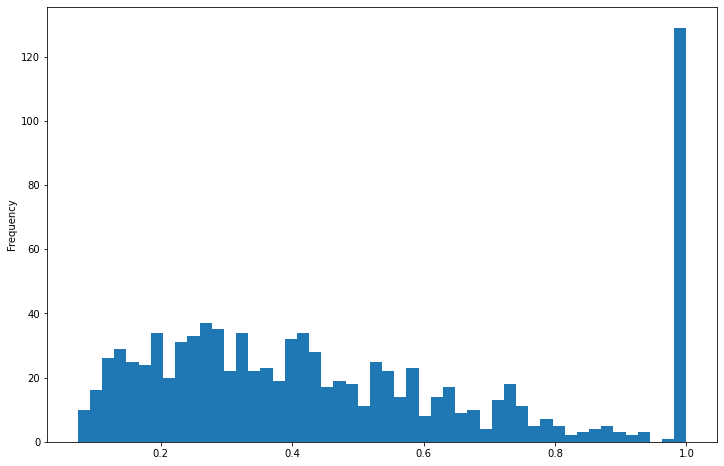

In [16]:
community_context_df['density'].plot.hist(bins=50, figsize=(12,8))

#### Investigate Communities

In [17]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

In [18]:
def show_author_papers(df, G):
    
    G = G.copy()
    
    check_nodes = G.nodes

    return sorted(df[df['authors'].isin(check_nodes)]['title'].unique())

In [19]:
def fetch_communities(community_context_df, min_density, max_density, max_nodes=None, n_communities=10):
    
    if max_nodes==None:
        community_context_df['node_count'].sum()
    
    community_context_df = community_context_df.copy()

    mask = (community_context_df['density']>min_density) \
        & (community_context_df['density']<max_density)  \
        & (community_context_df['node_count']<max_nodes)
    
    community_context_df = community_context_df[mask].copy()
    community_context_df = community_context_df.sample(n_communities) # grabbing ten to see the ranges

    community_context_df.sort_values('density', inplace=True)
    communities = community_context_df['community'].values[0:n_communities]
    
    return communities

In [20]:
def draw_community(G_check):

    print('Density: {}'.format(nx.density(G_check)))
    print('Node Count: {}'.format(len(G_check.nodes)))
    return draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

In [21]:
min_density = 0.1
max_density = 0.3
max_nodes = 100

# .1 to .3 has more papers and more variation
# .3 to .6 is very cool
# .6 to .8 is cool to describe smaller more densely connected groups

# i did several iterations to find titles; sparse communities seem to have more and more interesting papers (opinion)

communities = fetch_communities(community_context_df, min_density=min_density, max_density=max_density, max_nodes=max_nodes, n_communities=20)
communities

array([ 765, 2863, 1751,  802, 5034, 3132, 2001,   99, 1396, 2074, 4130,
       4668,  510,  172,  798,  684, 2308, 4035,  880,  553], dtype=int64)

Density: 0.12280701754385964
Node Count: 39


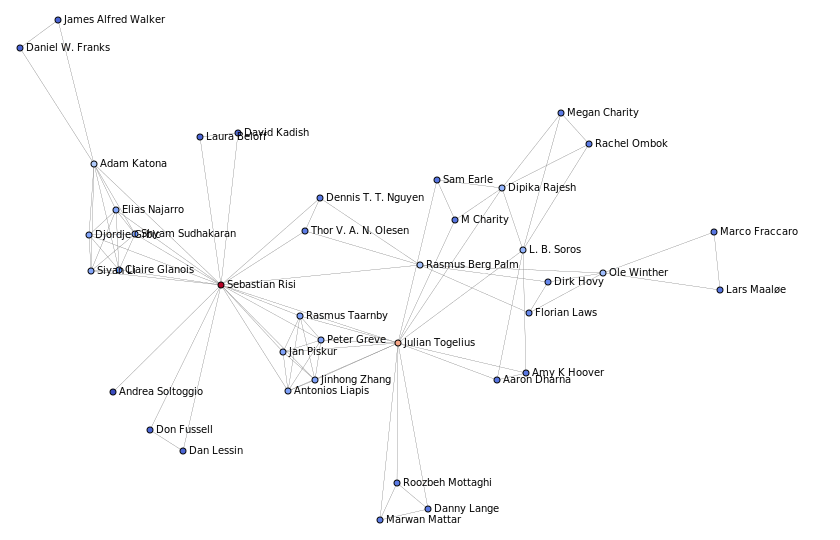

In [22]:
G_check = community_context_dict[communities[0]]['G']
draw_community(G_check)

In [24]:
show_author_papers(df, G_check)

#Efficient Top-k Ego-Betweenness Search
#Fast Algorithms for Intimate-Core Group Search in Weighted Graphs
#Fine-Grained Emotion Classification of Chinese Microblogs Based on Graph Convolution Networks
#Mining Bursting Communities in Temporal Graphs

['AAAI-2019 Workshop on Games and Simulations for Artificial Intelligence',
 'AI Researchers, Video Games Are Your Friends!',
 'Amorphous Fortress: Observing Emergent Behavior in Multi-Agent FSMs',
 'An artifcial life approach to studying niche differentiation in soundscape ecology',
 'Attend, Copy, Parse -- End-to-end information extraction from documents',
 'Born to Learn: the Inspiration, Progress, and Future of Evolved Plastic Artificial Neural Networks',
 'Co-generation of game levels and game-playing agents',
 'Collaborative Agent Gameplay in the Pandemic Board Game',
 'End-to-End Information Extraction without Token-Level Supervision',
 'Evolutionary Planning in Latent Space',
 'Growing 3D Artefacts and Functional Machines with Neural Cellular Automata',
 'HyperNCA: Growing Developmental Networks with Neural Cellular Automata',
 'Increasing Behavioral Complexity for Evolved Virtual Creatures with the ESP Method',
 'Keke AI Competition: Solving puzzle levels in a dynamically chan

Density: 0.12727272727272726
Node Count: 45


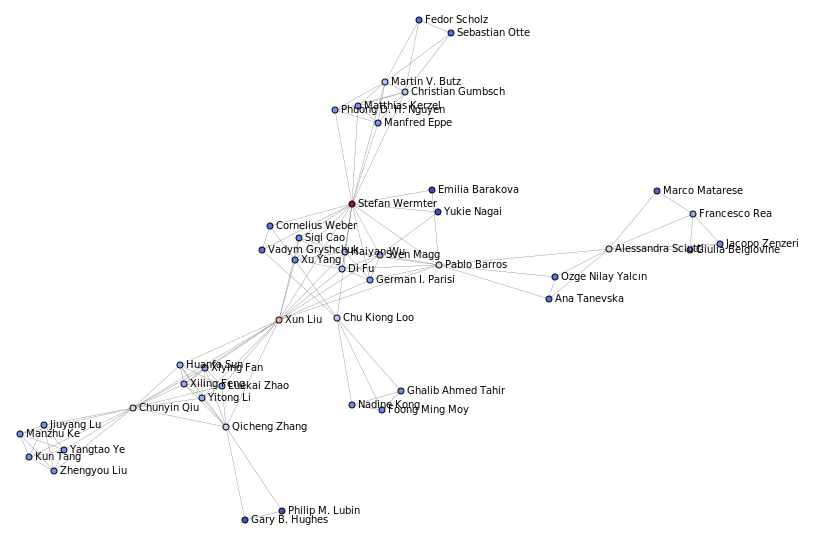

In [102]:
G_check = community_context_dict[communities[1]]['G']
draw_community(G_check)

In [26]:
show_author_papers(df, G_check)

#A Deep Learning Approach for Multimodal Deception Detection
#GraphTMT: Unsupervised Graph-based Topic Modeling from Video Transcripts
#RP-DNN: A Tweet level propagation context based deep neural networks for early rumor detection in Social Media
#Capturing Topology in Graph Pattern Matching
#Graph Pattern Matching for Dynamic Team Formation
#SceneRec: Scene-Based Graph Neural Networks for Recommender Systems

['A Deep Neural Model Of Emotion Appraisal',
 'A Humanoid Social Agent Embodying Physical Assistance Enhances Motor Training Experience',
 'A Review of Critical Features and General Issues of Freely Available mHealth Apps For Dietary Assessment',
 'A User-Centred Framework for Explainable Artificial Intelligence in Human-Robot Interaction',
 'Assessing the Contribution of Semantic Congruency to Multisensory Integration and Conflict Resolution',
 'Can AI detect pain and express pain empathy? A review from emotion recognition and a human-centered AI perspective',
 'Focusing and directional beaming effects of airborne sound through a planar lens with zigzag slits',
 'Hierarchical principles of embodied reinforcement learning: A review',
 'Highly efficient anomalous refraction of airborne sound through ultrathin metasurfaces',
 'Improving interactive reinforcement learning: What makes a good teacher?',
 'Incorporating Rivalry in Reinforcement Learning for a Competitive Game',
 'Inference o

Density: 0.1746031746031746
Node Count: 36


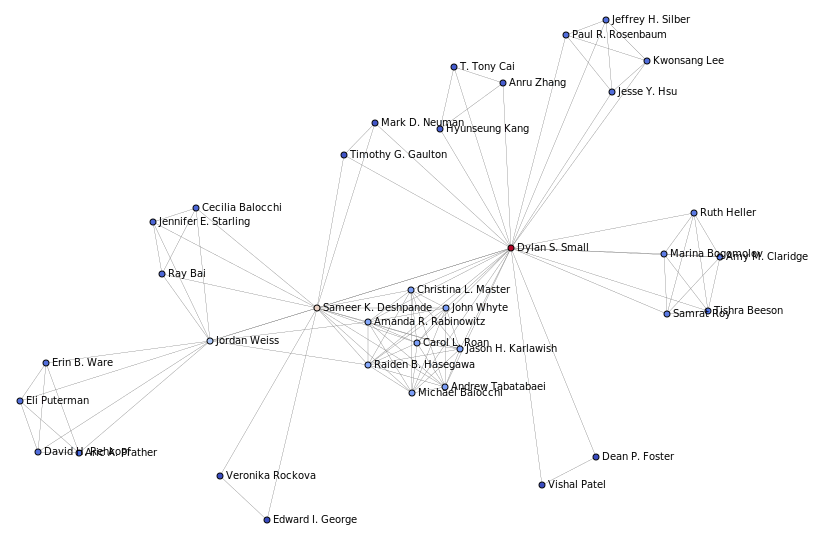

In [101]:
G_check = community_context_dict[communities[2]]['G']
draw_community(G_check)

In [28]:
show_author_papers(df, G_check)

#A Survey of Neural Trojan Attacks and Defenses in Deep Learning
#Physical world assistive signals for deep neural network classifiers -- neither defense nor attack
#PRAT: PRofiling Adversarial aTtacks
#Four hot DOGs in the microwave
#Outlyingness: why do outliers lie out?

['A data-driven prospective study of incident dementia among older adults in the United States',
 'Comment: The Place of Death in the Quality of Life',
 'Discovering Effect Modification in an Observational Study of Surgical Mortality at Hospitals with Superior Nursing',
 'Ideal Bayesian Spatial Adaptation',
 'Instrumental Variables Estimation with Some Invalid Instruments and its Application to Mendelian Randomization',
 'Protocol for an Observational Study of the Association of High School Football Participation on Health in Late Adulthood',
 'Protocol for an Observational Study on the Effects of Early-Life Participation in Contact Sports on Later-Life Cognition in a Sample of Monozygotic and Dizygotic Swedish Twins Reared Together and Twins Reared Apart',
 'Protocol for an Observational Study on the Effects of Giving Births from Unintended Pregnancies on Later Life Physical and Mental Health',
 'Protocol for an Observational Study on the Effects of Playing High School Football on Lat

Density: 0.19047619047619047
Node Count: 21


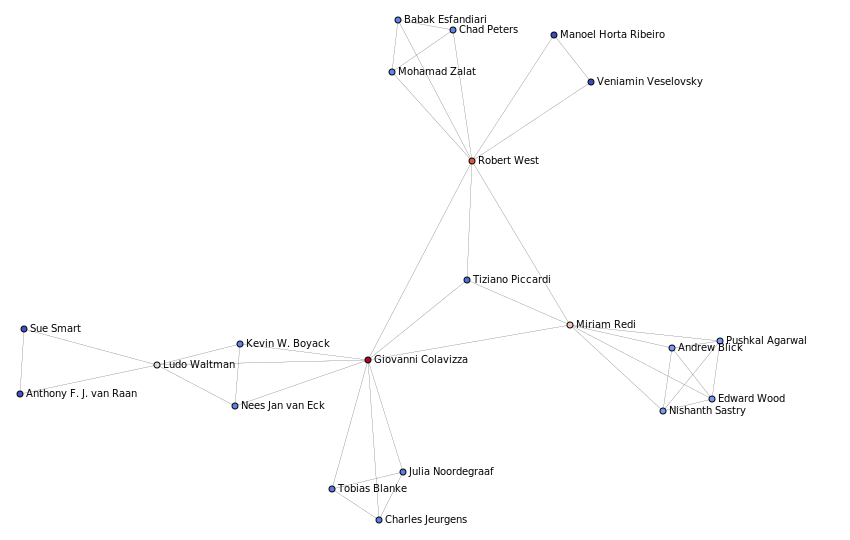

In [98]:
G_check = community_context_dict[communities[3]]['G']
draw_community(G_check)

In [30]:
show_author_papers(df, G_check)

#Natural Backdoor Attack on Text Data

['Archives and AI: An Overview of Current Debates and Future Perspectives',
 'Artificial Artificial Artificial Intelligence: Crowd Workers Widely Use Large Language Models for Text Production Tasks',
 'Behavior Cloning in OpenAI using Case Based Reasoning',
 'Characterizing in-text citations in scientific articles: A large-scale analysis',
 'Comparison of the Hirsch-index with standard bibliometric indicators and with peer judgment for 147 chemistry research groups',
 'Exploring the relationship between the Engineering and Physical Sciences and the Health and Life Sciences by advanced bibliometric methods',
 'Quantifying Engagement with Citations on Wikipedia',
 'Wikipedia and Westminster: Quality and Dynamics of Wikipedia Pages about UK Politicians']

Density: 0.1996996996996997
Node Count: 37


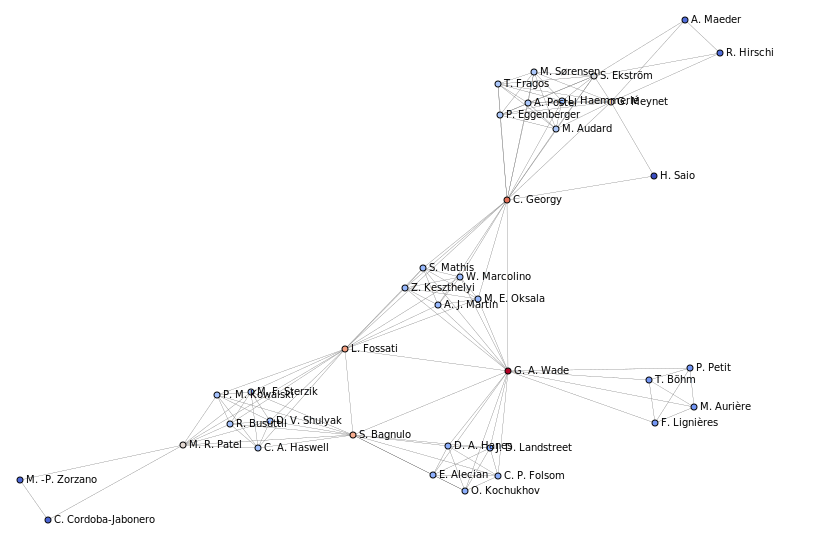

In [93]:
G_check = community_context_dict[communities[4]]['G']
draw_community(G_check)

In [32]:
show_author_papers(df, G_check)

#Entropy and the Predictability of Online Life

['Blue supergiants as descendants of magnetic main sequence stars',
 'Combining observational techniques to constrain convection in evolved massive star models',
 'Evolution of the Solar Activity over Time and Effects on Planetary Atmospheres: I. High-energy Irradiances (1-1700 A)',
 'First results from the LIFE project: discovery of two magnetic hot evolved stars',
 'Magnetic, Chemical and Rotational Properties of the Herbig Ae/Be Binary System HD 72106',
 'Powerful explosions at Z=0 ?',
 'Radiative Habitable Zones in Martian Polar Environments',
 'Reconstructing Extreme Space Weather from Planet Hosting Stars',
 'Stellar evolution with rotation XIII: Predicted GRB rates at various Z',
 'Stellar models and isochrones from low-mass to massive stars including pre-main sequence phase with accretion',
 'The dichotomy between strong and ultra-weak magnetic fields among intermediate-mass stars',
 'The evolution of magnetic fields from the main-sequence to very late stages',
 'The habitabili

Density: 0.2028985507246377
Node Count: 24


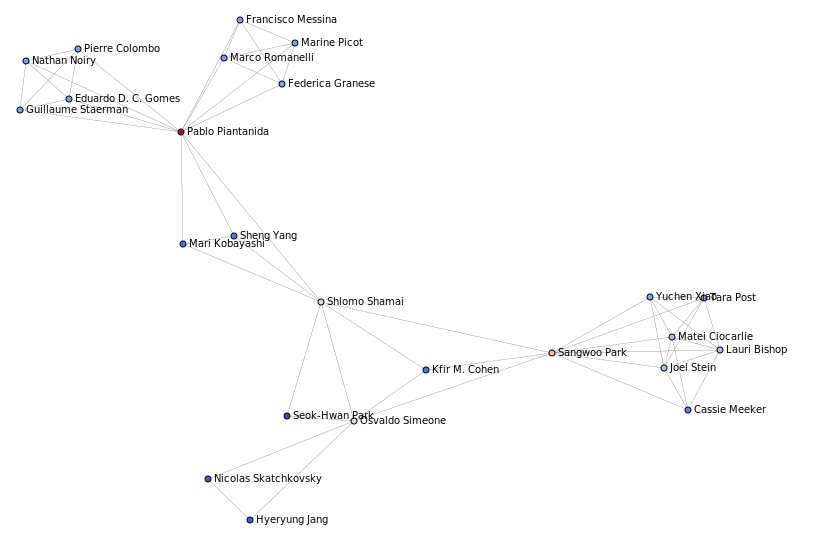

In [92]:
G_check = community_context_dict[communities[5]]['G']
draw_community(G_check)

In [34]:
show_author_papers(df, G_check)

#XENON1T Anomaly and its Implication for Decaying Warm Dark Matter
#Wandering in Color-Space -- why the life of pentaquark is so long ? --
#What can we learn from universal Turing machines?

['Bayesian Active Meta-Learning for Few Pilot Demodulation and Equalization',
 'Beyond Mahalanobis-Based Scores for Textual OOD Detection',
 'EMG Pattern Classification to Control a Hand Orthosis for Functional Grasp Assistance after Stroke',
 'Fronthaul Quantization as Artificial Noise for Enhanced Secret Communication in C-RAN',
 'Learning to Time-Decode in Spiking Neural Networks Through the Information Bottleneck',
 'MEAD: A Multi-Armed Approach for Evaluation of Adversarial Examples Detectors',
 'On the Feasibility of Wearable Exotendon Networks for Whole-Hand Movement Patterns in Stroke Patients',
 'Secrecy Degrees of Freedom of MIMO Broadcast Channels with Delayed CSIT']

Density: 0.20910384068278806
Node Count: 38


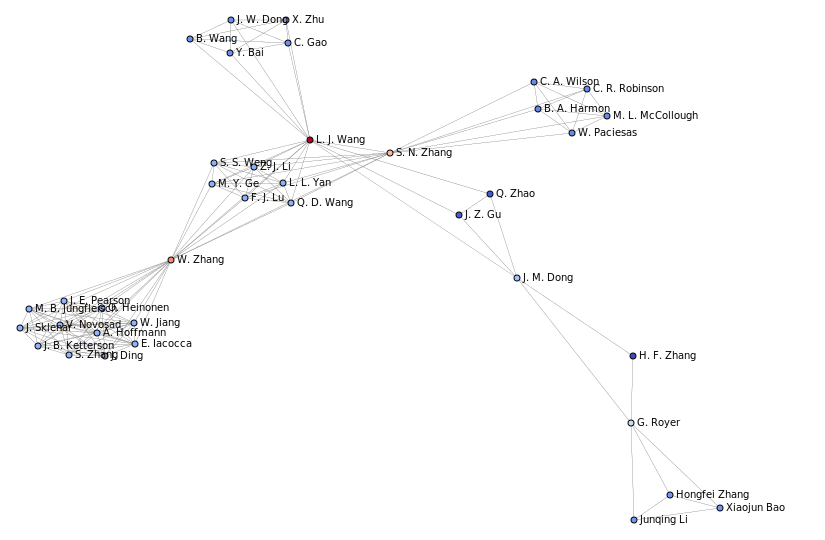

In [90]:
G_check = community_context_dict[communities[6]]['G']
draw_community(G_check)

In [36]:
show_author_papers(df, G_check)

#Causal Explanation Analysis on Social Media
#Overcoming Catastrophic Forgetting in Massively Multilingual Continual Learnin
#The Remarkable Benefit of User-Level Aggregation for Lexical-based Population-Level Predictions
#G-networks and the optimization of supply chains
#Lady and the Tramp Nextdoor: Online Manifestations of Economic Inequalities in the Nextdoor Social Network

['$α$ particle preformation in heavy nuclei and penetration probability',
 'Alpha-Cluster formation in heavy alpha-emitters within a multistep model',
 'Ar-39 Detection at the 10^-16 Isotopic Abundance Level with Atom Trap Trace Analysis',
 'Collective ferromagnetism of artificial square spin ice',
 'Dynamic response of an artificial square spin ice',
 'Five Years in the Life of Cygnus X-1: BATSE Long-Term Monitoring',
 'Proton radioactivity within a generalized liquid drop model',
 'Restricted Value Iteration: Theory and Algorithms',
 'Speeding Up the Convergence of Value Iteration in Partially Observable Markov Decision Processes',
 'Spontaneous fission half-lives of heavy and superheavy nuclei within a generalized liquid drop model',
 'Square Kilometer Array Telescope - Precision Reference Frequency Synchronisation via 1f-2f Dissemination',
 'The brightening of the pulsar wind nebula of PSR B0540--69 after its spin-down rate transition',
 'Tuning of the Quantum-Confined Stark Effect

Density: 0.2134387351778656
Node Count: 23


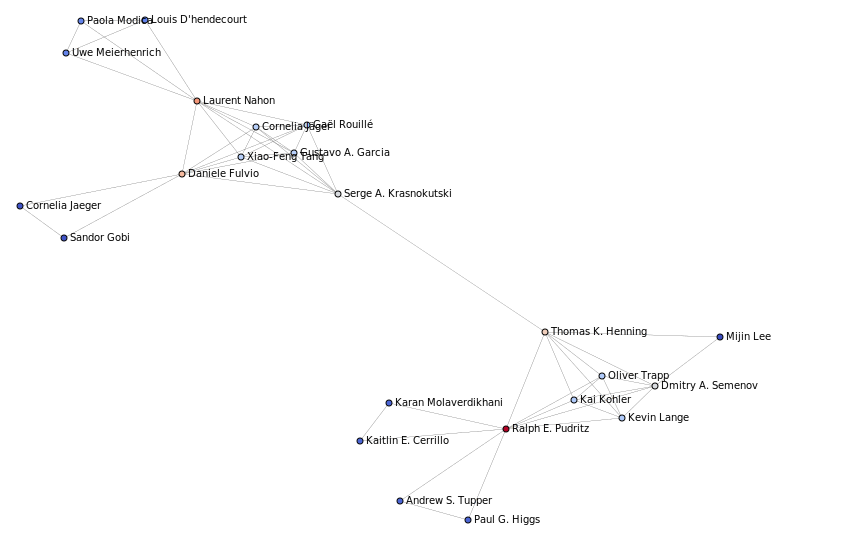

In [89]:
G_check = community_context_dict[communities[7]]['G']
draw_community(G_check)

In [38]:
show_author_papers(df, G_check)

#Real-Time Bidding by Reinforcement Learning in Display Advertising
#Ease-of-Teaching and Language Structure from Emergent Communication
#The Hanabi Challenge: A New Frontier for AI Research

['Constraining the Time Interval for the Origin of Life on Earth',
 'Did life originate from low-temperature areas of the Universe?',
 'Dissociative photoionization of polycyclic aromatic hydrocarbon molecules carrying an ethynyl group',
 'Experimental Characterization of the Energetics of Low-temperature Surface Reactions',
 "HCN production in Titan's Atmosphere: Coupling quantum chemistry and disequilibrium atmospheric modeling",
 'Interstellar ices: a possible scenario for symmetry breaking of extraterrestrial chiral organic molecules of prebiotic interest',
 'Laboratory experiments on the low temperature formation of carbonaceous grains in the ISM',
 'Possible Ribose Synthesis in Carbonaceous Planetesimals',
 'Prebiotic Vitamin B$_3$ Synthesis in Carbonaceous Planetesimals',
 'Towards RNA life on Early Earth: From atmospheric HCN to biomolecule production in warm little ponds']

Density: 0.22666666666666666
Node Count: 25


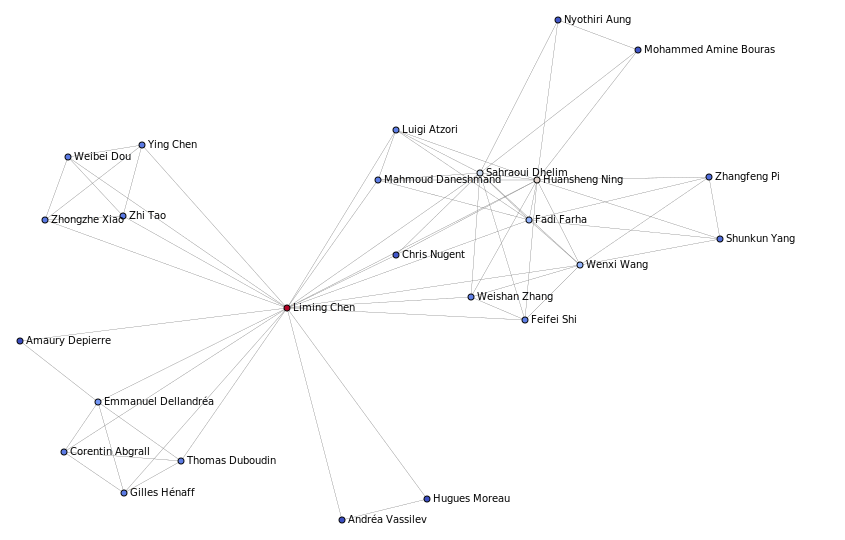

In [87]:
G_check = community_context_dict[communities[8]]['G']
draw_community(G_check)

In [40]:
show_author_papers(df, G_check)

#Large Graph Models: A Perspective

['A Review on Serious Games for Disaster Relief',
 'A Survey of Hybrid Human-Artificial Intelligence for Social Computing',
 'A Survey on Personality-Aware Recommendation Systems',
 'Artificial Intelligence for Suicide Assessment using Audiovisual Cues: A Review',
 'Data Fusion for Deep Learning on Transport Mode Detection: A Case Study',
 'Encouraging Intra-Class Diversity Through a Reverse Contrastive Loss for Better Single-Source Domain Generalization',
 'IoT-Enabled Social Relationships Meet Artificial Social Intelligence',
 'Jacquard: A Large Scale Dataset for Robotic Grasp Detection',
 'Look Beyond Bias with Entropic Adversarial Data Augmentation',
 'MES-P: an Emotional Tonal Speech Dataset in Mandarin Chinese with Distal and Proximal Labels']

Density: 0.23723723723723725
Node Count: 37


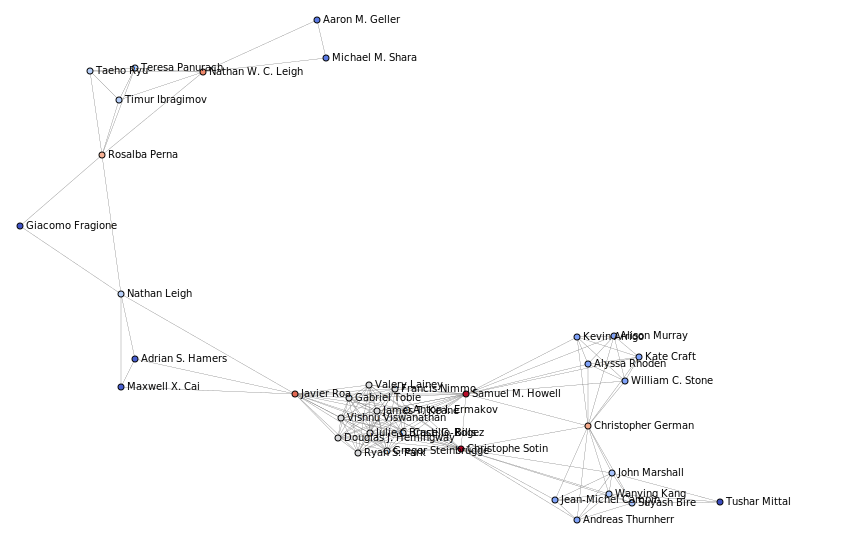

In [104]:
G_check = community_context_dict[communities[9]]['G']
draw_community(G_check)

In [42]:
show_author_papers(df, G_check)

#Does the evolution of complex life depend on the stellar spectral energy distribution?
#Funding the Search for Extraterrestrial Intelligence with a Lottery Bond
#Why do we find ourselves around a yellow star instead of a red star?
#Find the Conversation Killers: a Predictive Study of Thread-ending Posts -- HELL YES

['A Recipe for Geophysical Exploration of Enceladus',
 'Black hole and neutron star mergers in Galactic Nuclei: the role of triples',
 'Differing Enceladean ocean circulation and ice shell geometries driven by tidal heating in the ice versus the core',
 'Dynamics or Geysers and tracer transport over the south pole of Enceladus',
 'Ocean Worlds Exploration and the Search for Life',
 'Stability of exomoons around the Kepler transiting circumbinary planets',
 'When do star clusters become multiple star systems? II. Toward a half-life formalism with four bodies',
 'When does a star cluster become a multiple star system? I. Lifetimes of equal-mass small-N systems']

Density: 0.2450638792102207
Node Count: 42


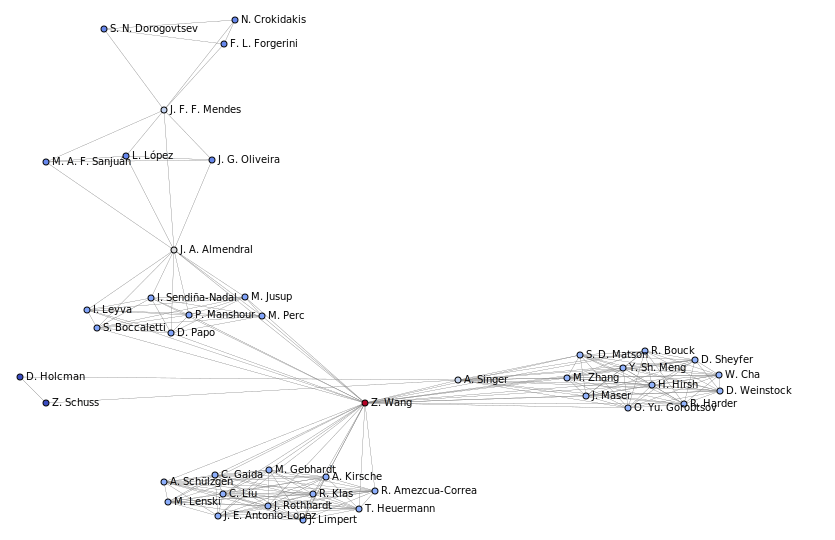

In [43]:
G_check = community_context_dict[communities[10]]['G']
draw_community(G_check)

In [44]:
show_author_papers(df, G_check)

#SCB-dataset: A Dataset for Detecting Student Classroom Behavior
#SCB-Dataset3: A Benchmark for Detecting Student Classroom Behavior
#Did life originate from low-temperature areas of the Universe?

['Bright, high-repetition-rate water window soft X-ray source enabled by nonlinear pulse self-compression in an antiresonant hollow-core fibre',
 'Diverse strategic identities induce dynamical states in evolutionary games',
 'Evolution of spatially embedded branching trees with interacting nodes',
 'Interaction and transformation of metastable defects in intercalation materials',
 'Multiple peaks patterns of epidemic spreading in multi-layer networks',
 'Narrow Escape, Part II: The circular disk',
 'Narrow Escape, Part III: Riemann surfaces and non-smooth domains',
 'Spin-Fluctuation-Induced Non-Fermi-Liquid Behavior with suppressed superconductivity in LiFe$_{1-x}$Co$_{x}$As',
 'The interplay of university and industry through the FP5 network']

Density: 0.24615384615384617
Node Count: 26


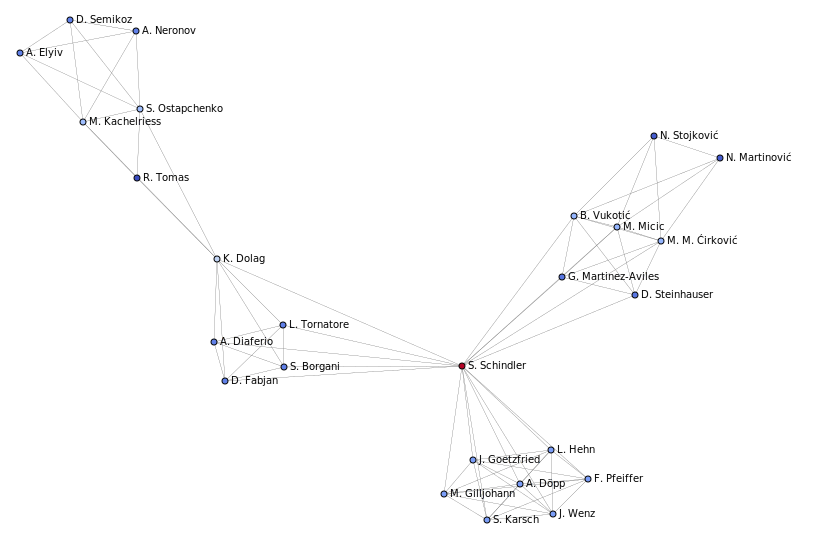

In [45]:
G_check = community_context_dict[communities[11]]['G']
draw_community(G_check)

In [46]:
show_author_papers(df, G_check)

#BEAMERS: Brain-Engaged, Active Music-based Emotion Regulation System
#Human-Like Intuitive Behavior and Reasoning Biases Emerged in Language Models -- and Disappeared in GPT-4
#Local Causal Structure Learning and its Discovery Between Type 2 Diabetes and Bone Mineral Density
#Machine Psychology: Investigating Emergent Capabilities and Behavior in Large Language Models Using Psychological Methods
#SINGA-Easy: An Easy-to-Use Framework for MultiModal Analysis
#Secure Artificial Intelligence of Things for Implicit Group Recommendations
#Thinking Fast and Slow in Large Language Models
#Cultures in Community Question Answering
#On the Behaviour of Deviant Communities in Online Social Networks
#Uncovering Bias in Personal Informatics

['"Grandeur in this view of life": N-body simulation models of the Galactic habitable zone',
 'Astrobiological Complexity with Probabilistic Cellular Automata',
 'Degree-scale GeV "jets" from active and dead TeV blazars',
 'Galactic Habitability Re-Examined: Indications of Bimodality',
 'Lower limit on the strength and filling factor of extragalactic magnetic fields',
 'Quick X-ray microtomography using a laser-driven betatron source',
 'Search for Tri-Nucleon Decay in the Majorana Demonstrator',
 'The chemical enrichment of the ICM from hydrodynamical simulations']

Density: 0.26842105263157895
Node Count: 20


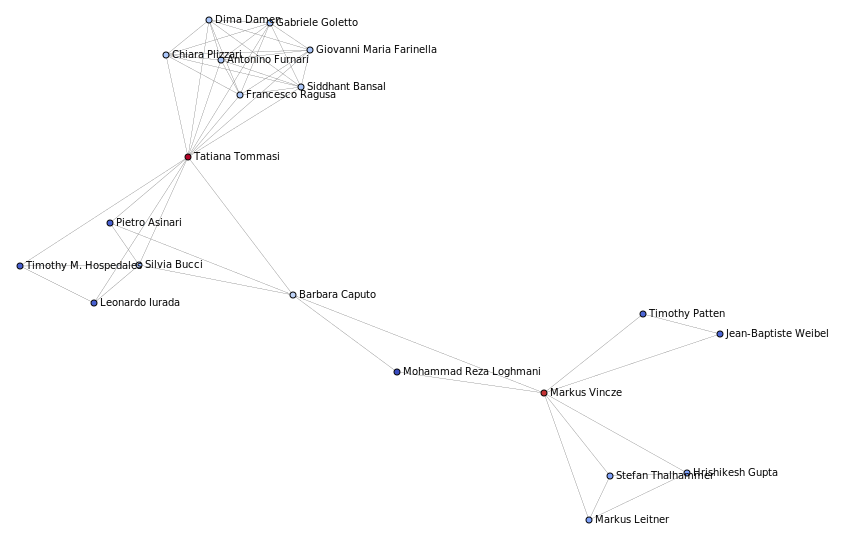

In [47]:
G_check = community_context_dict[communities[12]]['G']
draw_community(G_check)

In [48]:
show_author_papers(df, G_check)

#Computational Metacognition
#Large Language Models for User Interest Journeys

['An Outlook into the Future of Egocentric Vision',
 'Ego4D: Around the World in 3,000 Hours of Egocentric Video',
 'Fairness meets Cross-Domain Learning: a new perspective on Models and Metrics',
 'Grasping the Inconspicuous',
 "Making AI 'Smart': Bridging AI and Cognitive Science",
 'Recognizing Objects In-the-wild: Where Do We Stand?',
 'Sim2Real 3D Object Classification using Spherical Kernel Point Convolution and a Deep Center Voting Scheme',
 'Towards Fairness Certification in Artificial Intelligence']

Density: 0.27058823529411763
Node Count: 35


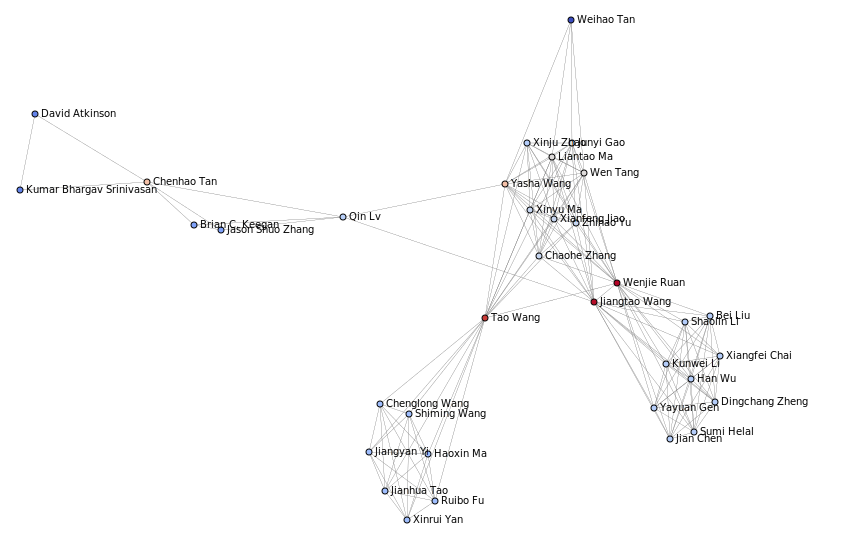

In [49]:
G_check = community_context_dict[communities[13]]['G']
draw_community(G_check)

In [50]:
show_author_papers(df, G_check)

#A Survey on Personality-Aware Recommendation Systems
#MES-P: an Emotional Tonal Speech Dataset in Mandarin Chinese with Distal and Proximal Labels

['All Who Wander: On the Prevalence and Characteristics of Multi-community Engagement',
 'Ask Not What AI Can Do, But What AI Should Do: Towards a Framework of Task Delegability',
 'Autocorrect in the Process of Translation -- Multi-task Learning Improves Dialogue Machine Translation',
 'CFAD: A Chinese Dataset for Fake Audio Detection',
 'Cell Selection with Deep Reinforcement Learning in Sparse Mobile Crowdsensing',
 'CovidCare: Transferring Knowledge from Existing EMR to Emerging Epidemic for Interpretable Prognosis',
 'Crowd-Powered Sensing and Actuation in Smart Cities: Current Issues and Future Directions',
 'Grasp stability prediction with time series data based on STFT and LSTM',
 'Interpretable Machine Learning for COVID-19: An Empirical Study on Severity Prediction Task',
 'MUSEFood: Multi-sensor-based Food Volume Estimation on Smartphones',
 'Mortality Prediction with Adaptive Feature Importance Recalibration for Peritoneal Dialysis Patients: a deep-learning-based study on a

Density: 0.27816091954022987
Node Count: 30


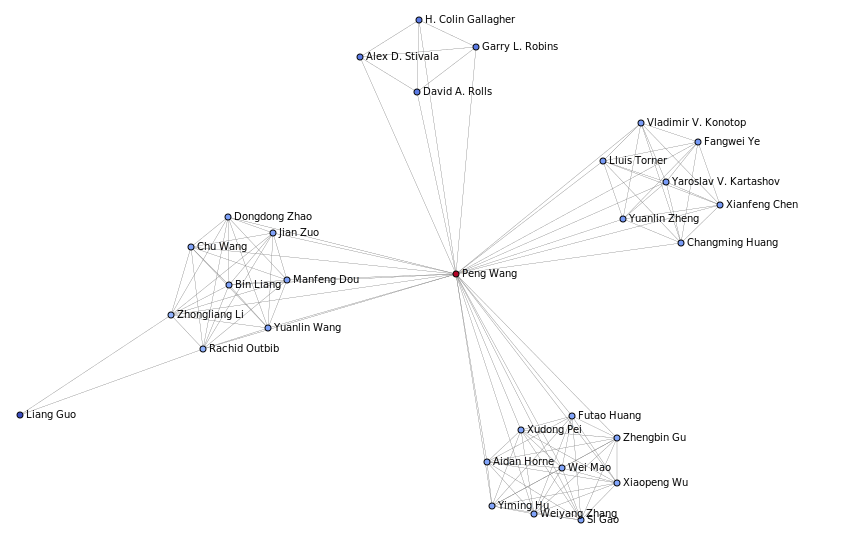

In [84]:
G_check = community_context_dict[communities[14]]['G']
draw_community(G_check)

In [52]:
show_author_papers(df, G_check)

#Can Requirements Engineering Support Explainable Artificial Intelligence? Towards a User-Centric Approach for Explainability Requirements


['4D-Explorer: A visual software for 4D-STEM data processing and image reconstruction',
 'A Lifetime Extended Energy Management Strategy for Fuel Cell Hybrid Electric Vehicles via Self-Learning Fuzzy Reinforcement Learning',
 'A Wearable ECG Monitor for Deep Learning Based Real-Time Cardiovascular Disease Detection',
 'Data-driven prognostics based on time-frequency analysis and symbolic recurrent neural network for fuel cells under dynamic load',
 'Localization and delocalization of light in photonic moire lattices',
 'Negative-ResNet: Noisy Ambulatory Electrocardiogram Signal Classification Scheme',
 'Using Sampled Network Data With The Autologistic Actor Attribute Model']

Density: 0.2782258064516129
Node Count: 32


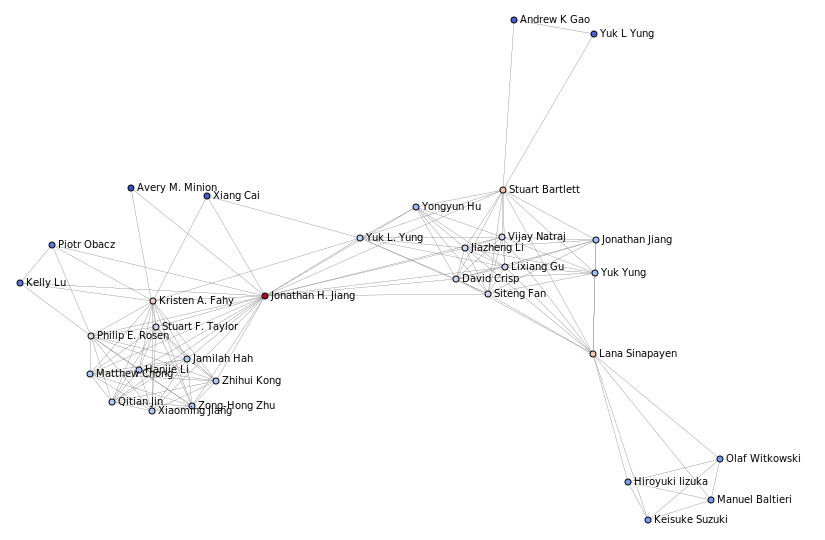

In [82]:
G_check = community_context_dict[communities[15]]['G']
draw_community(G_check)

In [54]:
show_author_papers(df, G_check)

#AutoHEnsGNN: Winning Solution to AutoGraph Challenge for KDD Cup 2020
#Malware Detection using Artificial Bee Colony Algorithm
##Bigbirds Never Die: Understanding Social Dynamics of Emergent Hashtag
#The Systemic Impact of Deplatforming on Social Media
#The Twitter of Babel: Mapping World Languages through Microblogging Platforms

['A Beacon in the Galaxy: Updated Arecibo Message for Potential FAST and SETI Projects',
 'A Statistical Estimation of the Occurrence of Extraterrestrial Intelligence in the Milky Way Galaxy',
 'An active inference implementation of phototaxis',
 'Assessing Planetary Complexity and Potential Agnostic Biosignatures using Epsilon Machines',
 'Avoiding the "Great Filter": Extraterrestrial Life and Humanity\'s Future in the Universe',
 'Biosignatures from Earth-Like Planets Around M Dwarfs',
 'Chemical Heredity as Group Selection at the Molecular Level',
 'Computation by Convective Logic Gates and Thermal Communication',
 "DNN Architecture for High Performance Prediction on Natural Videos Loses Submodule's Ability to Learn Discrete-World Dataset",
 'Earth as a Proxy Exoplanet: Deconstructing and Reconstructing Spectrophotometric Light Curves',
 "Emergence, Construction, or Unlikely? Navigating the Space of Questions regarding Life's Origins",
 'Evolutionary Generation of Visual Motion Illu

Density: 0.2807017543859649
Node Count: 19


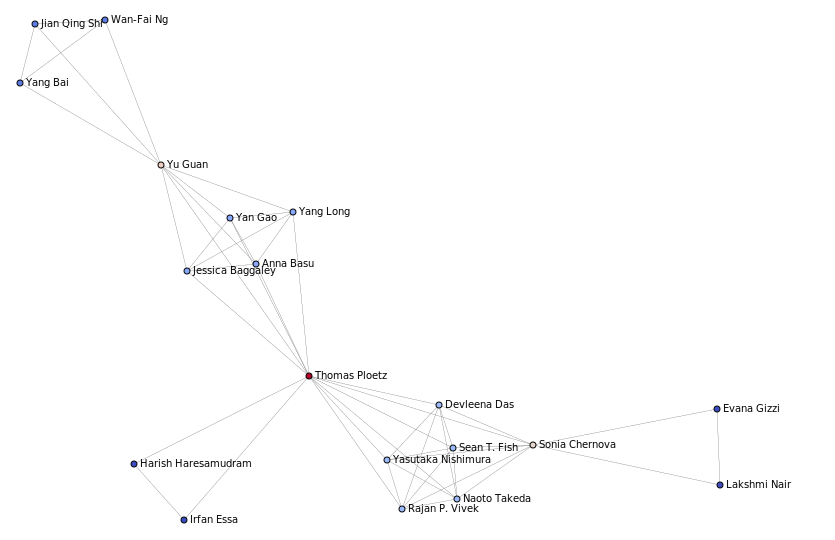

In [76]:
G_check = community_context_dict[communities[16]]['G']
draw_community(G_check)

In [56]:
show_author_papers(df, G_check)

['Contrastive Predictive Coding for Human Activity Recognition',
 'Creative Problem Solving in Artificially Intelligent Agents: A Survey and Framework',
 'Ensembles of Deep LSTM Learners for Activity Recognition using Wearables',
 'Explainable AI for Robot Failures: Generating Explanations that Improve User Assistance in Fault Recovery',
 'Explainable AI for System Failures: Generating Explanations that Improve Human Assistance in Fault Recovery',
 'Explainable Activity Recognition for Smart Home Systems',
 'Fatigue Assessment using ECG and Actigraphy Sensors',
 'Towards Automated Fatigue Assessment using Wearable Sensing and Mixed-Effects Models',
 'Towards Reliable, Automated General Movement Assessment for Perinatal Stroke Screening in Infants Using Wearable Accelerometers']

Density: 0.29004329004329005
Node Count: 22


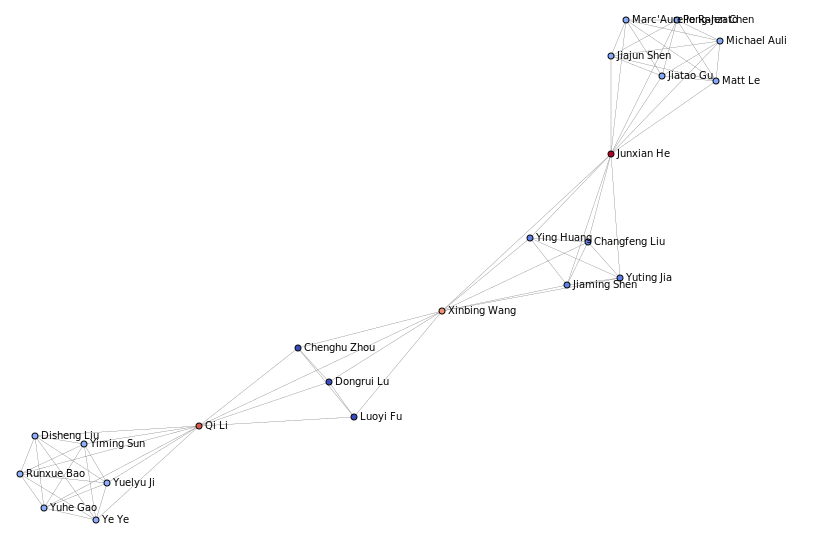

In [71]:
G_check = community_context_dict[communities[17]]['G']
draw_community(G_check)

In [58]:
show_author_papers(df, G_check)

#Mining the Social Media Data for a Bottom-Up Evaluation of Walkability

["Can We `Feel' the Temperature of Knowledge? Modelling Scientific Popularity Dynamics via Thermodynamics",
 "Prediction of COVID-19 Patients' Emergency Room Revisit using Multi-Source Transfer Learning",
 'Text Network Exploration via Heterogeneous Web of Topics',
 'The Source-Target Domain Mismatch Problem in Machine Translation']

Density: 0.29347826086956524
Node Count: 24


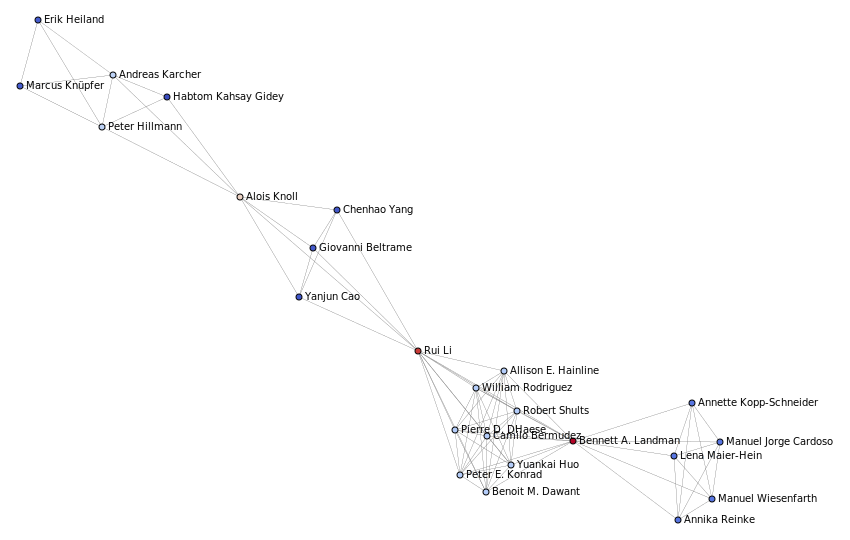

In [69]:
G_check = community_context_dict[communities[18]]['G']
draw_community(G_check)

In [60]:
show_author_papers(df, G_check)

#A Large-scale Friend Suggestion Architecture
#Towards Cognitive Bots: Architectural Research Challenges

['A Large-scale Friend Suggestion Architecture',
 'Accurate position tracking with a single UWB anchor',
 'Methods and open-source toolkit for analyzing and visualizing challenge results',
 'Selective Deletion in a Blockchain',
 'Towards Cognitive Bots: Architectural Research Challenges',
 'Towards Machine Learning Prediction of Deep Brain Stimulation (DBS) Intra-operative Efficacy Maps']

Density: 0.2964426877470356
Node Count: 23


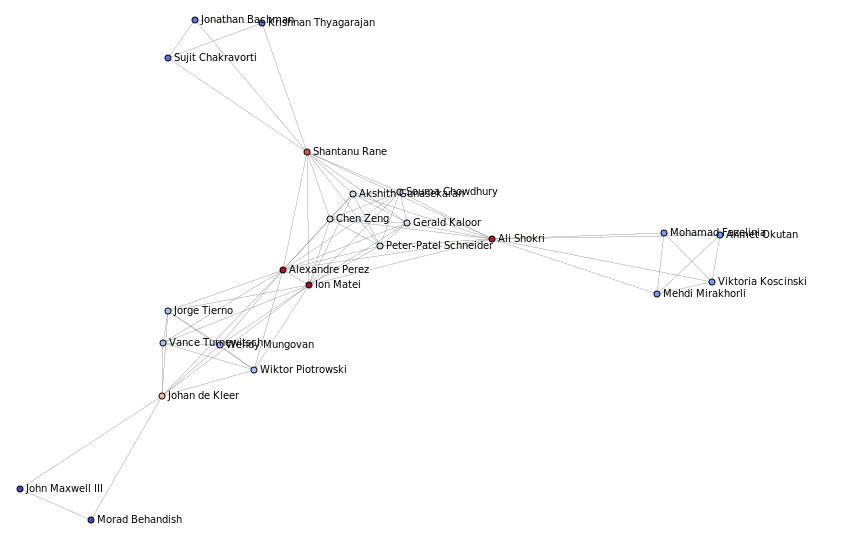

In [61]:
G_check = community_context_dict[communities[19]]['G']
draw_community(G_check)

In [62]:
show_author_papers(df, G_check)

['A Novel Approach to Identify Security Controls in Source Code',
 'AI Research Associate for Early-Stage Scientific Discovery',
 'CONSTRUCT: A Program Synthesis Approach for Reconstructing Control Algorithms from Embedded System Binaries in Cyber-Physical Systems',
 'Incentivizing Gigaton-Scale Carbon Dioxide Removal via a Climate-Positive Blockchain',
 'Surrogate Modeling for Physical Systems with Preserved Properties and Adjustable Tradeoffs',
 'System Resilience through Health Monitoring and Reconfiguration']

# Get Papers of Interest

In a separate text file, I add the papers I am interested in reading. I can then copy and paste them here, and do a quick 'split' to convert it into a useful list, which I can use to get URLs from the original DataFrame. 

In [63]:
papers = """
Efficient Top-k Ego-Betweenness Search
Fast Algorithms for Intimate-Core Group Search in Weighted Graphs
Fine-Grained Emotion Classification of Chinese Microblogs Based on Graph Convolution Networks
Mining Bursting Communities in Temporal Graphs
A Deep Learning Approach for Multimodal Deception Detection
GraphTMT: Unsupervised Graph-based Topic Modeling from Video Transcripts
RP-DNN: A Tweet level propagation context based deep neural networks for early rumor detection in Social Media
Capturing Topology in Graph Pattern Matching
Graph Pattern Matching for Dynamic Team Formation
SceneRec: Scene-Based Graph Neural Networks for Recommender Systems
A Survey of Neural Trojan Attacks and Defenses in Deep Learning
Physical world assistive signals for deep neural network classifiers -- neither defense nor attack
PRAT: PRofiling Adversarial aTtacks
Four hot DOGs in the microwave
Outlyingness: why do outliers lie out?
Natural Backdoor Attack on Text Data
Entropy and the Predictability of Online Life
XENON1T Anomaly and its Implication for Decaying Warm Dark Matter
Wandering in Color-Space -- why the life of pentaquark is so long ? --
What can we learn from universal Turing machines?
Causal Explanation Analysis on Social Media
Overcoming Catastrophic Forgetting in Massively Multilingual Continual Learnin
The Remarkable Benefit of User-Level Aggregation for Lexical-based Population-Level Predictions
G-networks and the optimization of supply chains
Lady and the Tramp Nextdoor: Online Manifestations of Economic Inequalities in the Nextdoor Social Network
Real-Time Bidding by Reinforcement Learning in Display Advertising
Ease-of-Teaching and Language Structure from Emergent Communication
The Hanabi Challenge: A New Frontier for AI Research
Large Graph Models: A Perspective
Does the evolution of complex life depend on the stellar spectral energy distribution?
Funding the Search for Extraterrestrial Intelligence with a Lottery Bond
Why do we find ourselves around a yellow star instead of a red star?
Find the Conversation Killers: a Predictive Study of Thread-ending Posts
SCB-dataset: A Dataset for Detecting Student Classroom Behavior
SCB-Dataset3: A Benchmark for Detecting Student Classroom Behavior
Did life originate from low-temperature areas of the Universe?
BEAMERS: Brain-Engaged, Active Music-based Emotion Regulation System
Human-Like Intuitive Behavior and Reasoning Biases Emerged in Language Models -- and Disappeared in GPT-4
Local Causal Structure Learning and its Discovery Between Type 2 Diabetes and Bone Mineral Density
Machine Psychology: Investigating Emergent Capabilities and Behavior in Large Language Models Using Psychological Methods
SINGA-Easy: An Easy-to-Use Framework for MultiModal Analysis
Secure Artificial Intelligence of Things for Implicit Group Recommendations
Thinking Fast and Slow in Large Language Models
Cultures in Community Question Answering
On the Behaviour of Deviant Communities in Online Social Networks
Uncovering Bias in Personal Informatics
Computational Metacognition
Large Language Models for User Interest Journeys
A Survey on Personality-Aware Recommendation Systems
MES-P: an Emotional Tonal Speech Dataset in Mandarin Chinese with Distal and Proximal Labels
Can Requirements Engineering Support Explainable Artificial Intelligence? Towards a User-Centric Approach for Explainability Requirements
AutoHEnsGNN: Winning Solution to AutoGraph Challenge for KDD Cup 2020
Malware Detection using Artificial Bee Colony Algorithm
Bigbirds Never Die: Understanding Social Dynamics of Emergent Hashtag
The Systemic Impact of Deplatforming on Social Media
The Twitter of Babel: Mapping World Languages through Microblogging Platforms
Mining the Social Media Data for a Bottom-Up Evaluation of Walkability
A Large-scale Friend Suggestion Architecture
Towards Cognitive Bots: Architectural Research Challenges
"""

In [64]:
papers_of_interest = [p for p in papers.split('\n') if len(p)>0]
papers_of_interest[0:5] # preview of first five

['Efficient Top-k Ego-Betweenness Search',
 'Fast Algorithms for Intimate-Core Group Search in Weighted Graphs',
 'Fine-Grained Emotion Classification of Chinese Microblogs Based on Graph Convolution Networks',
 'Mining Bursting Communities in Temporal Graphs',
 'A Deep Learning Approach for Multimodal Deception Detection']

In [65]:
# get the papers; reload data to get original format

data = r'C:\Users\groov\PythonCode\100daysofnetworks\data\arxiv_artificial_life.csv'

df = pd.read_csv(data)

df = df[df['title'].isin(papers_of_interest)]
df.sort_values('date_published', inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,date_published,title,authors,summary,url,category
0,2004-08-04 13:29:07+00:00,Wandering in Color-Space -- why the life of pe...,"['Yuu Maezawa', 'Toshiki Maruyama', 'Naoyuki I...",The problem of the long life time of the penta...,http://arxiv.org/pdf/hep-ph/0408056v4,hep-ph
1,2011-12-31 05:34:57+00:00,Capturing Topology in Graph Pattern Matching,"['Shuai Ma', 'Yang Cao', 'Wenfei Fan', 'Jinpen...",Graph pattern matching is often defined in ter...,http://arxiv.org/pdf/1201.0229v1,cs.DB
2,2012-12-20 20:43:12+00:00,The Twitter of Babel: Mapping World Languages ...,"['Delia Mocanu', 'Andrea Baronchelli', 'Bruno ...",Large scale analysis and statistics of socio-t...,http://arxiv.org/pdf/1212.5238v1,physics.soc-ph
3,2013-11-11 15:40:35+00:00,Funding the Search for Extraterrestrial Intell...,['Jacob Haqq-Misra'],I propose the establishment of a SETI Lottery ...,http://arxiv.org/pdf/1311.2467v2,physics.pop-ph
4,2013-12-01 01:34:09+00:00,Entropy and the Predictability of Online Life,"['Roberta Sinatra', 'Michael Szell']",Using mobile phone records and information the...,http://arxiv.org/pdf/1312.0169v2,physics.soc-ph


In [66]:
categories_by_size = df['category'].value_counts().index.values
categories_by_size

array(['cs.CL', 'cs.SI', 'cs.LG', 'cs.CV', 'cs.AI', 'cs.DB', 'hep-ph',
       'cs.CR', 'physics.soc-ph', 'physics.pop-ph', 'cs.CY',
       'astro-ph.EP', 'cs.IR', 'cs.SE', 'cs.FL', 'cs.SD', 'q-bio.QM',
       'math.OC', 'stat.ME', 'astro-ph.GA', 'cs.HC'], dtype=object)

In [67]:
for category in categories_by_size:
    
    print('Category: {}'.format(category))
    print()

    category_df = df[df['category']==category][['title', 'url', 'date_published']].copy()
    
    for row in category_df.iterrows():
        
        data = row[1]
        title = data['title']
        url = data['url']
        date_published = data['date_published']
        
        print('Title: {}\nDate Published: {}\nURL: {}'.format(title, date_published, url))
        print()
    

Category: cs.CL

Title: Find the Conversation Killers: a Predictive Study of Thread-ending Posts
Date Published: 2017-12-22 19:58:01+00:00
URL: http://arxiv.org/pdf/1712.08636v1

Title: A Deep Learning Approach for Multimodal Deception Detection
Date Published: 2018-03-01 12:38:13+00:00
URL: http://arxiv.org/pdf/1803.00344v1

Title: Causal Explanation Analysis on Social Media
Date Published: 2018-09-04 19:06:34+00:00
URL: http://arxiv.org/pdf/1809.01202v2

Title: Fine-Grained Emotion Classification of Chinese Microblogs Based on Graph Convolution Networks
Date Published: 2019-12-05 12:56:28+00:00
URL: http://arxiv.org/pdf/1912.02545v1

Title: Natural Backdoor Attack on Text Data
Date Published: 2020-06-29 16:40:14+00:00
URL: http://arxiv.org/pdf/2006.16176v4

Title: GraphTMT: Unsupervised Graph-based Topic Modeling from Video Transcripts
Date Published: 2021-05-04 12:48:17+00:00
URL: http://arxiv.org/pdf/2105.01466v4

Title: Thinking Fast and Slow in Large Language Models
Date Publishe

This last box proved very useful in seeing papers by category and date, to quickly skip papers that looked a bit too old. Use this to skim your papers of interest.  

I also noticed that arXiv returns the same paper duplicated by category, so that is something to deduplicated on another day.